Original code from https://github.com/eriklindernoren/Keras-GAN/blob/master/dcgan/dcgan.py

In [1]:
%matplotlib inline

In [3]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

In [4]:
# Global Constants
images_dir = "dcgan_images"
img_rows = 28 
img_cols = 28
channels = 1
noise_len = 100

In [5]:
def build_discriminator():

    img_shape = (img_rows, img_cols, channels)

    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [6]:
def build_generator():

    noise_shape = (noise_len,)

    model = Sequential()

    model.add(Dense(128 * 7 * 7, activation="relu", input_shape=noise_shape))
    model.add(Reshape((7, 7, 128)))
    model.add(BatchNormalization(momentum=0.8))
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8)) 
    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(1, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))

    return model

In [7]:
def build_combined():
    optimizer = Adam(0.0002, 0.5)

    # Build the discriminator. It will be compiled later, since we have to toggle trainability
    discriminator = build_discriminator()

    # Build and compile the generator
    generator = build_generator()
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)

    # The generator takes noise as input and generates images
    noise = Input(shape=(noise_len,))
    img = generator(noise)

    # The discriminator takes generated images as input and determines validity
    valid = discriminator(img)

    # The combined model  (stacked generator and discriminator) takes
    # noise as input => generates images => determines validity 
    combined = Model(inputs=noise, outputs=valid)
    return optimizer, generator, discriminator, combined

In [8]:
def save_imgs(generator, epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, noise_len))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    #fig.suptitle("DCGAN: Generated digits", fontsize=12)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig(os.path.join(images_dir, 'mnist_{}.png'.format(epoch)))
    plt.close()

In [9]:
def train(optimizer, generator, discriminator, combined, epochs, batch_size=128, save_interval=50):

    # Load the dataset
    (X_train, _), (_, _) = mnist.load_data()

    # Rescale -1 to 1
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)

    half_batch = int(batch_size / 2)

    for epoch in range(epochs):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random half batch of images
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]

        # Sample noise and generate a half batch of new images
        noise = np.random.normal(0, 1, (half_batch, noise_len))
        gen_imgs = generator.predict(noise)
        
        # Allow the weights to train during this step
        discriminator.trainable = True
        # You must compile the model after changing trainable. Recompiling does not reset the weights.
        discriminator.compile(loss='binary_crossentropy', 
                              optimizer=optimizer,
                              metrics=['accuracy'])

        # Train the discriminator (real classified as ones and generated as zeros)
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        noise = np.random.normal(0, 1, (batch_size, noise_len))
        
        # For the combined model we will only train the generator
        discriminator.trainable = False
        # We have to recompile after we change the trainability of part of the model. This does not change the weights.
        combined.compile(loss='binary_crossentropy', optimizer=optimizer)

        # Train the generator (wants discriminator to mistake images as real)
        g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))

        # Plot the progress
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

        # If at save interval => save generated image samples
        if epoch % save_interval == 0:
            save_imgs(generator, epoch)

In [10]:
def show_new_image(generator):
    noise = np.random.normal(0, 1, (1, noise_len))
    gen_img = generator.predict(noise)[0][:,:,0]
    
    return plt.imshow(gen_img, cmap='gray', vmin=-1, vmax=1)

In [11]:
# set up directories
import os

if (not os.path.isdir(images_dir)):
    os.mkdir(images_dir)

In [12]:
optimizer, generator, discriminator, combined = build_combined()

In [13]:
train(optimizer, generator, discriminator, combined, epochs=1, batch_size=32, save_interval=50)

0 [D loss: 0.898608, acc.: 53.12%] [G loss: 0.964149]


The first images:
![](dcgan_images/mnist_0.png)
The last images (epoch 100):
![](dcgan_images/mnist_100.png)

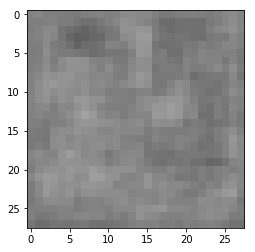

In [14]:
show_new_image(generator)